In [99]:
import pandas as pd 
import numpy as np 
import json 

In [100]:
#First, update accuracy for preference data
def compute_preference_accuracy(df):
    import re
    responses = json.loads(df.iloc[0]['answers'])
    drawings = json.loads(df.iloc[0]['drawings'].replace("\'", "\""))


    def extract_metric(drawing_name):
        match = re.search(r'l(\d+)', drawing_name)
        return int(match.group(1)) if match else None

    data = []
    for row in range(df.shape[0]):
        data.append([])
        responses = json.loads(df.iloc[row]['answers'])
        drawings = json.loads(df.iloc[row]['drawings'].replace("\'", "\""))
        for i, (pair, response) in enumerate(zip(drawings, responses)):
            metric_1 = extract_metric(pair[0])
            metric_2 = extract_metric(pair[1])
            metric_diff = metric_2 - metric_1
            
            preferred_higher_metric = 1 if (response == 2 and metric_diff > 0) or (response == 1 and metric_diff < 0) else 0
            
            data[-1].append({'metric_diff': abs(metric_diff), 'accuracy': preferred_higher_metric})

    return data

Index(['Unnamed: 0', 'drawings', 'answers', 'time', 'strategy',
       'overall_confidence', 'difficulty', 'familiarity', 'age', 'gender',
       'Finished', 'prolific_id', 'StartDate', 'EndDate', 'stress_familiarity',
       'correct_answers', 'deltas', 'accuracy']

In [101]:
import os 
pname = 'cleaned_data/'
for fname in os.listdir(pname):
    df = pd.read_csv(f"{pname}{fname}",index_col=0)
    df.to_json(f"json_data/{fname.split('.')[0]}.json",orient='records',indent=4)

In [ ]:
pname = 'json_data/'
for fname in os.listdir(pname):
    print(fname)
    with open(pname + fname, 'r') as fdata:
        data = json.load(fdata)

    if 'expert' not in fname:
        for participant in data:
            #parse lists we might want to use later
            for key in ['drawings', 'answers', 'confidence', 'time', 'accuracy']:
                if key in participant:
                    participant[key] = json.loads(participant[key].replace('\'', '\"'))

            for i,d in enumerate(participant['drawings']):
                d1,d2 = d 
                n1 = int(d1.split("_")[1].replace("l",""))
                n2 = int(d2.split("_")[1].replace("l",""))
                if n1 - n2 == 0: participant['accuracy'][i] = -1                    

    with open(pname + fname, 'w') as fdata:
        json.dump(data,fdata,indent=4)

nt_stress50-cleaned.json
preference50-cleaned.json
preference25-cleaned.json
stress25-cleaned.json
stress50-cleaned.json
nt_stress10-cleaned.json
preference10-cleaned.json
stress_expert-cleaned.json
stress10-cleaned.json
nt_stress25-cleaned.json


In [ ]:
with open("json_data/stress_expert-cleaned.json", 'r') as fdata:
    data = json.load(fdata)

for p in data:
    for n in [10,25,50]:
        p[n] = {
            'drawings': json.loads(p[f'drawings{n}'].replace('\'', '\"')),
            'time': json.loads(p[f'time{n}']),
            'accuracy': json.loads(p[f'accuracy{n}'])
        }
        for i,d in enumerate(p[n]['drawings']):
            d1,d2 = d 
            n1 = int(d1.split("_")[1].replace("l",""))
            n2 = int(d2.split("_")[1].replace("l",""))
            if n1 - n2 == 0: p[n]['accuracy'][i] = -1

with open("json_data/stress_expert-cleaned.json", 'w') as fdata:
    json.dump(data,fdata,indent=4)

In [104]:
#Correct accuracy for preference
for n in [10,25,50]:
    with open(f"json_data/preference{n}-cleaned.json", 'r') as fdata:
        data = json.load(fdata)
    
    # for p in data:
    #     acc = list()
    #     same_stress = list()
    #     for i,pair in enumerate(p['drawings']):
    #         left, right = pair 
    #         left = int(left.split("_")[1].replace("l",''))
    #         right = int(right.split("_")[1].replace("l",''))

    #         if left > right: acc.append(1 if p['answers'][i] == 1 else 0)
    #         elif left < right: acc.append(1 if p['answers'][i] == 2 else 0)
    #         else: acc.append(0)

    #     p['drawings'] = [d for i,d in enumerate(p['drawings']) if i not in same_stress]        
    #     p['accuracy'] = acc
    
    with open(f"json_data/preference{n}-cleaned.json", 'w') as fdata:
        json.dump(data,fdata,indent=4)

In [105]:
n = 10

In [106]:
from collections import defaultdict 
stresstest = defaultdict(list)
stressdelta = defaultdict(list)

for n in [10, 25, 50]:
    for f in [f'stress{n}-cleaned.json', f'nt_stress{n}-cleaned.json', 'stress_expert-cleaned.json']:

        with open(f'json_data/{f}', 'r') as fdata:
            data = json.load(fdata)

        for p in data:
            if 'expert' in f: p = p[f'{n}']
            for i,d in enumerate(p['drawings']):
                
                d1,d2 = d 
                n1 = int(d1.split("_")[1].replace("l",""))
                n2 = int(d2.split("_")[1].replace("l",""))
                delta = abs(n1-n2)

                if delta > 0: stresstest[tuple(sorted(d))].append(p['accuracy'][i])

                if delta > 0:
                    stressdelta[delta].append(p['accuracy'][i])


In [107]:
preftest = defaultdict(list)
prefdelta = defaultdict(list)
prefcount = defaultdict(complex)

for n in [10,25,50]:
    with open(f'json_data/preference{n}-cleaned.json', 'r') as fdata:
        data = json.load(fdata)

    for i,p in enumerate(data):
        for j,d in enumerate(p['drawings']):


            d1,d2 = d 
            n1 = int(d1.split("_")[1].replace("l",""))
            n2 = int(d2.split("_")[1].replace("l",""))
            delta = abs(n1-n2)

            if delta > 0: preftest[tuple(sorted(d))].append(p['accuracy'][i])

            if delta > 0:
                prefdelta[delta].append(p['accuracy'][j])

            prefcount[d1] += 1j 
            prefcount[d2] += 1j

            if p["answers"][j] == 1: prefcount[d1] += 1 
            if p['answers'][j] == 2: prefcount[d2] += 1 

In [108]:
combined = dict()

for k1 in stresstest.keys():
    if k1 in preftest: 
        combined[k1] = {
            "stress": stresstest[k1],
            "preference": preftest[k1]
        }


In [109]:
stressvpref = defaultdict(float)
for dpair in combined.keys():
    gd_response = combined[dpair]['stress']
    pref_response = combined[dpair]['preference']
    frac = 0 
    for gdr in gd_response: 
        for prr in pref_response:
            if gdr == prr: frac += 1
    stressvpref[dpair] = frac / (len(gd_response) * len(pref_response))

In [110]:
stressvpref

defaultdict(float,
            {('g3_l60_a', 'g3_l70_b'): 0.44,
             ('g4_l40_b', 'g4_l75_c'): 0.7857142857142857,
             ('g1_l55_c', 'g1_l80_b'): 1.0,
             ('g5_l60_b', 'g5_l75_c'): 0.8333333333333334,
             ('g4_l40_a', 'g4_l80_c'): 0.7,
             ('g4_l40_b', 'g4_l55_a'): 0.5,
             ('g2_l70_c', 'g2_l80_a'): 0.5,
             ('g1_l45_c', 'g1_l75_b'): 0.4166666666666667,
             ('g5_l60_a', 'g5_l65_b'): 0.4,
             ('g3_l40_c', 'g3_l75_a'): 0.625,
             ('g3_l45_c', 'g3_l60_a'): 0.6666666666666666,
             ('g5_l40_a', 'g5_l80_b'): 0.6706730769230769,
             ('g2_l55_c', 'g2_l80_a'): 0.48333333333333334,
             ('g1_l40_a', 'g1_l50_c'): 0.375,
             ('g2_l40_b', 'g2_l80_c'): 0.8,
             ('g3_l45_b', 'g3_l75_a'): 0.2,
             ('g5_l40_c', 'g5_l75_b'): 0.9411764705882353,
             ('g2_l45_c', 'g2_l60_b'): 0.6,
             ('g5_l45_b', 'g5_l70_a'): 0.7142857142857143,
             ('g4_l

Text(0, 0.5, 'Number of pairs of drawings')

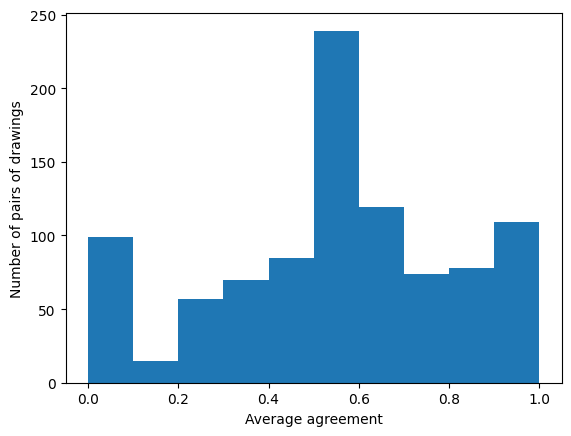

In [111]:
import pylab as plt 
plt.hist(stressvpref.values(),bins=10)
plt.xlabel("Average agreement")
plt.ylabel("Number of pairs of drawings")

In [112]:
def get_delta(d1,d2):
    n1 = int(d1.split("_")[1].replace("l",""))
    n2 = int(d2.split("_")[1].replace("l",""))
    return abs(n1-n2)

Text(0, 0.5, 'Difference in KSM')

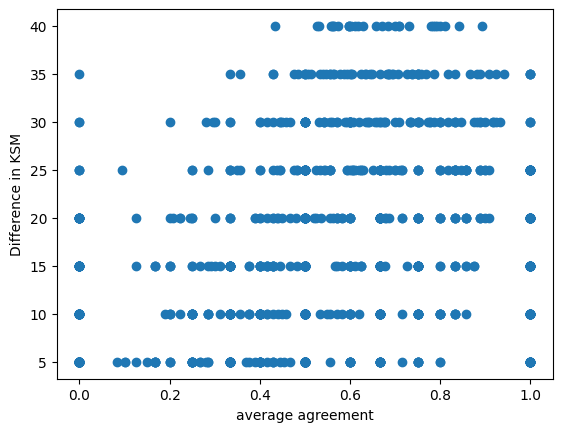

In [113]:
plt.scatter(stressvpref.values(), [get_delta(d1,d2) for d1,d2 in stressvpref.keys()])
plt.xlabel("average agreement")
plt.ylabel("Difference in KSM")
# [gpair for gpair in stressvpref.keys()]

In [114]:
from scipy.stats import pearsonr
x = np.array([x for x in stressvpref.values()],dtype=np.float32)
y = np.array([get_delta(d1,d2) for d1,d2 in stressvpref.keys()],dtype=np.float32)
pearsonr(x,y)

PearsonRResult(statistic=0.3271112616043865, pvalue=5.274417e-25)

In [115]:
with open("dump.json", 'w') as fdata:
    json.dump(combined,fdata,indent=4)

TypeError: keys must be str, int, float, bool or None, not tuple

In [ ]:
from scipy.stats import pearsonr

data = combined

# Initialize lists for averages
stress_averages = []
preference_averages = []

# Iterate over each entry
for key, value in data.items():
    # Compute averages
    stress_avg = np.mean(value['stress']) if value['stress'] else None
    preference_avg = np.mean(value['preference']) if value['preference'] else None

    # Skip entries where averages cannot be calculated
    if stress_avg is not None and preference_avg is not None:
        stress_averages.append(stress_avg)
        preference_averages.append(preference_avg)

# Compute Pearson correlation
correlation, p_value = pearsonr(stress_averages, preference_averages)

print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation: -0.005027971388807721
P-value: 0.9202497033465522


Eliminate same stress pairs
Count fraction of times they agree (pairwise entries)
All graph sizes 

In [ ]:
import pylab as plt

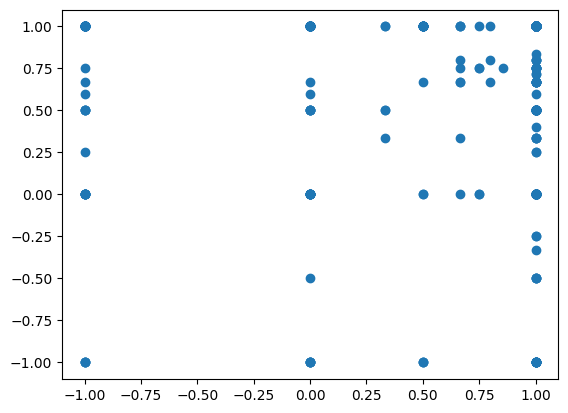

In [ ]:
plt.scatter(stress_averages, preference_averages)

In [ ]:
for key in stressdelta.keys():
    print(key, len(stressdelta[key]), len(prefdelta[key]))

10 125 125
35 125 125
25 125 125
15 125 125
40 125 125
30 125 125
5 125 125
0 125 125
20 125 125


In [ ]:
def draw(table, ax):
    # Define labels for groups and categories
    groups = ['Stress', "Preference"]
    categories = ['Successes', 'Failures']

    # Transpose data to stack categories for each group
    stacked_data = table.T

    # Create a stacked bar chart
    x = np.arange(len(groups))  # Group positions on x-axis

    # Plot each category
    for i, category_data in enumerate(stacked_data):
        ax.bar(x, category_data, label=categories[i], bottom=stacked_data[:i].sum(axis=0))

    # Add labels, title, and legend
    ax.set_xticks(x)
    ax.set_yticks([])
    ax.set_xticklabels(groups)
    # ax.set_ylabel('Frequency')
    # ax.set_title('Stacked Bar Chart of Successes and Failures')
    # ax.legend(title='Category')

    return ax

delta = 5
[[59 66]
 [74 51]]
0.07597826391555276

delta = 10
[[68 57]
 [86 39]]
0.027059039225753666

delta = 15
[[88 37]
 [87 38]]
1.0

delta = 20
[[106  19]
 [105  20]]
1.0

delta = 25
[[108  17]
 [102  23]]
0.3883673584627567

delta = 30
[[109  16]
 [114  11]]
0.4150314117242222

delta = 35
[[117   8]
 [104  21]]
0.017786045714454052

delta = 40
[[113  12]
 [110  15]]
0.6836145603362381



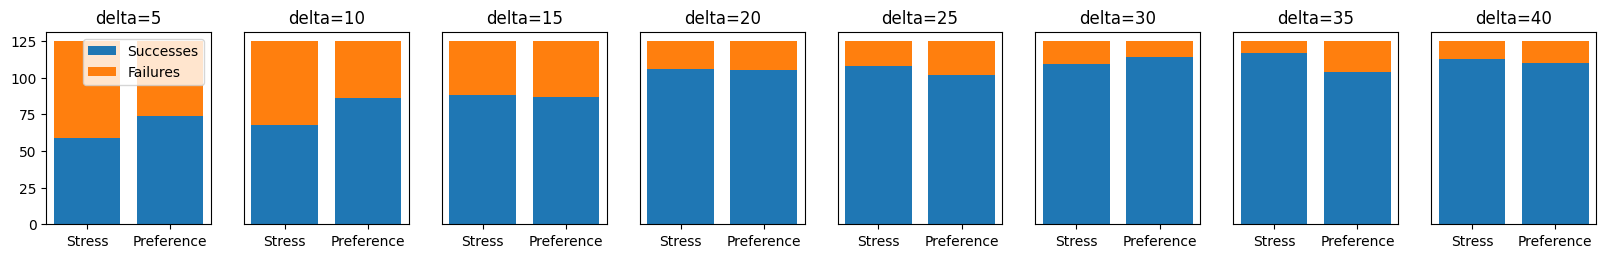

In [ ]:
from scipy.stats import binomtest,chi2_contingency
import pylab as plt
fig, axes = plt.subplots(1,8)
for delta, ax in zip(range(5,41,5), axes):
    print(f"delta = {delta}")
    stress0 = stressdelta[delta].count(0)
    stress1 = stressdelta[delta].count(1)
    pref0   = prefdelta[delta].count(0)
    pref1   = prefdelta[delta].count(1)

    ctable = np.array([
        [stress1, stress0], 
        [pref1, pref0]
    ])
    print(ctable)

    res = chi2_contingency(ctable)
    print(res.pvalue)
    print()

    draw(ctable,ax)
    ax.set_title(f"delta={delta}")

ax = axes[0]
ax.set_yticks(np.linspace(0,125,6,dtype=int))
ax.legend()



fig.set_size_inches(20,20/8)
fig.savefig("test.png")

In [ ]:
xy = {key: {
    'x': val.real / val.imag, 
    'y': int(key.split("_")[1].replace("l", "")) / 100, 
    'selected': int(val.real),
    'seen': int(val.imag), 
} for key,val in prefcount.items()}

xy

{'g4_l40_c': {'x': 0.3235294117647059, 'y': 0.4, 'selected': 11, 'seen': 34},
 'g4_l45_b': {'x': 0.25, 'y': 0.45, 'selected': 3, 'seen': 12},
 'g5_l70_a': {'x': 0.85, 'y': 0.7, 'selected': 17, 'seen': 20},
 'g5_l65_c': {'x': 0.4666666666666667, 'y': 0.65, 'selected': 7, 'seen': 15},
 'g2_l50_c': {'x': 0.19047619047619047, 'y': 0.5, 'selected': 4, 'seen': 21},
 'g2_l60_b': {'x': 0.47058823529411764, 'y': 0.6, 'selected': 8, 'seen': 17},
 'g5_l50_b': {'x': 0.2222222222222222, 'y': 0.5, 'selected': 4, 'seen': 18},
 'g5_l80_a': {'x': 0.6842105263157895, 'y': 0.8, 'selected': 13, 'seen': 19},
 'g2_l50_b': {'x': 0.0, 'y': 0.5, 'selected': 0, 'seen': 9},
 'g2_l70_c': {'x': 0.9411764705882353, 'y': 0.7, 'selected': 16, 'seen': 17},
 'g1_l55_a': {'x': 0.18181818181818182, 'y': 0.55, 'selected': 2, 'seen': 11},
 'g1_l55_c': {'x': 0.8181818181818182, 'y': 0.55, 'selected': 9, 'seen': 11},
 'g2_l40_b': {'x': 0.08333333333333333, 'y': 0.4, 'selected': 2, 'seen': 24},
 'g2_l75_a': {'x': 0.8, 'y': 0.

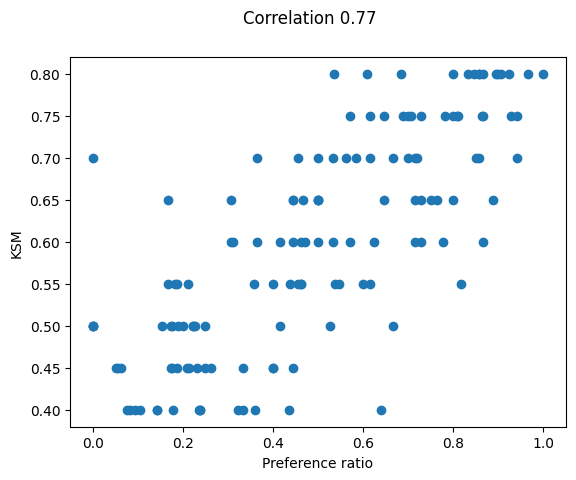

In [ ]:
x = [v['x'] for v in xy.values()]
y = [v['y'] for v in xy.values()]

plt.scatter(x,y)
plt.suptitle(f"Correlation {0.77}")
plt.xlabel("Preference ratio")
plt.ylabel("KSM")
plt.savefig("correlation.png")

In [ ]:
r = pearsonr(x,y).statistic
